In [1]:
import gymnasium as gym
from gymnasium import spaces
import hockey.hockey_env as h_env
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
# class DiscreteActionWrapper(gym.ActionWrapper):
#     def __init__(self, env: gym.Env, bins = 8):
#         """A wrapper for converting a 1D continuous actions into discrete ones.
#         Args:
#             env: The environment to apply the wrapper
#             bins: number of discrete actions
#         """
#         assert isinstance(env.action_space, spaces.Box)
#         super().__init__(env)
#         self.bins = bins
#         self.orig_action_space = env.action_space
#         self.action_space = spaces.Discrete(self.bins)
        
#     def action(self, action):
#         """ discrete actions from low to high in 'bins'
#         Args:
#             action: The discrete action
#         Returns:
#             continuous action
#         """
#         return self.env.discrete_to_continous_action(action)

# DQN and RND

In [3]:
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, hidden_sizes=[100,100], 
                 learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()
    
    def fit(self, observations, actions, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(observations).float(), acts)
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def Q_value(self, observations, actions):
        return self.forward(observations).gather(1, actions[:,None])        
    
    def maxQ(self, observations):
        return np.max(self.predict(observations), axis=-1, keepdims=True)
        
    def greedyAction(self, observations):
        return np.argmax(self.predict(observations), axis=-1)        

class RND():
    def __init__(self, input_dim, output_dim, hidden_dim=[100,100],
                 learning_rate = 0.0001):
        self.target = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.predictor = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.optimizer=torch.optim.Adam(self.predictor.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.MSELoss()

    def intrinsic_reward(self, observations):
        output_target = self.target(observations).detach()
        output_prediction = self.predictor(observations)
        reward = self.loss(output_target, output_prediction)
        return reward

    def update_pred(self, reward):
        reward.backward()
        self.optimizer.step()
        

In [4]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.2,            # Epsilon in epsilon greedy policies                        
            "eps_decay": 0.98,     # Epsilon decay rate
            "eps_min": 0.001,      # Minimum epsilon
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

In [5]:
# dqn and rnd agent
class DQNRNDAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.2,            # Epsilon in epsilon greedy policies 
            "eps_decay": 0.98,     # Epsilon decay rate
            "eps_min": 0.001,       # Minimum epsilon                       
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "learning_rate_rnd": 0.0001,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])

        # RND
        self.rnd = RND(input_dim=self._observation_space.shape[0], 
                       output_dim=self._action_n,
                       learning_rate = self._config["learning_rate_rnd"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)

            rew_i = self.rnd.intrinsic_reward(torch.from_numpy(s.astype(np.float32)))
            self.rnd.update_pred(rew_i)  # update predictor      
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

## Test in Env

In [35]:
# env_name = 'Pendulum-v1'
# # env_name = 'CartPole-v0'
# env = gym.make(env_name)

env = h_env.HockeyEnv() #mode=h_env.Mode.TRAIN_SHOOTING # mode=h_env.Mode.TRAIN_DEFENSE
env.discretize_actions(8)

# if isinstance(env.action_space, spaces.Box):
#     print("Discretizing actions")
#     env = DiscreteActionWrapper(env)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(8)
Box(-inf, inf, (18,), float32)
[(np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf)), (np.float32(-inf), np.float32(inf))]


### No RND

In [7]:
use_target = True
target_update = 20
q_agent = DQNAgent(o_space, ac_space, discount=0.98, eps=1.0, learning_rate=0.0002,
                   use_target_net=use_target, update_target_every= target_update)

In [8]:
ob,_info = env.reset()
obs_agent2 = env.obs_agent_two()
player2 = h_env.BasicOpponent(weak=True)
print(q_agent.Q.predict(ob))

[ 0.10412973  0.07494387 -0.02101459  0.1582093  -0.07240549 -0.1741461
  0.20198074 -0.07579602]


Running some episodes

In [36]:
stats = []
losses = []
wins = []

In [37]:
max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    obs_agent2 = env.obs_agent_two() 
    for t in range(max_steps):
        done = False        
        a1_discrete = q_agent.act(ob)
        a1 = env.action(a1_discrete)
        a2 = player2.act(obs_agent2) #np.random.uniform(-1,1,4)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1,a2]))
        total_reward+= reward
        q_agent.store_transition((ob, a1_discrete, reward, ob_new, done))            
        ob=ob_new
        obs_agent2 = env.obs_agent_two()        
        if done or trunc: break 
    wins.append(_info['winner'])
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    

    if q_agent._eps > q_agent._config['eps_min']:
        q_agent._eps *= q_agent._config['eps_decay']    
    
    if ((i-1)%20==0):
        sum_wins = np.sum(np.array(wins)==1)
        print("{}: Done after {} steps. Reward: {}. Total wins: {}".format(i, t+1, total_reward, sum_wins))

1: Done after 37 steps. Reward: -10.702402017748469. Total wins: 1
21: Done after 251 steps. Reward: -0.6437478551343142. Total wins: 3
41: Done after 91 steps. Reward: 8.567268320282498. Total wins: 7
61: Done after 60 steps. Reward: 11.496881769430683. Total wins: 11
81: Done after 71 steps. Reward: -10.25468372877891. Total wins: 11
101: Done after 19 steps. Reward: 10.627373567170535. Total wins: 17
121: Done after 62 steps. Reward: 11.462986077097806. Total wins: 20
141: Done after 185 steps. Reward: -9.9676011622857. Total wins: 23
161: Done after 251 steps. Reward: -2.3010855186252392. Total wins: 27
181: Done after 251 steps. Reward: 0.0637322935564999. Total wins: 30
201: Done after 41 steps. Reward: 10.449631033130322. Total wins: 33
221: Done after 171 steps. Reward: -18.692494074198066. Total wins: 37
241: Done after 160 steps. Reward: -11.386095437321323. Total wins: 44
261: Done after 164 steps. Reward: 10.110364214149145. Total wins: 47
281: Done after 156 steps. Reward:

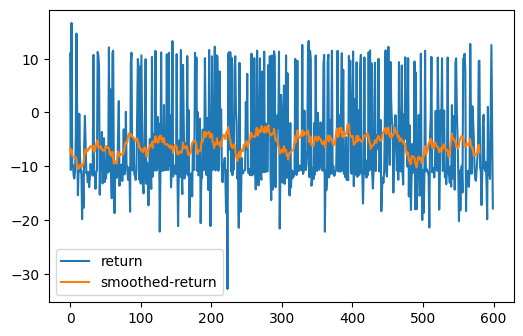

In [38]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

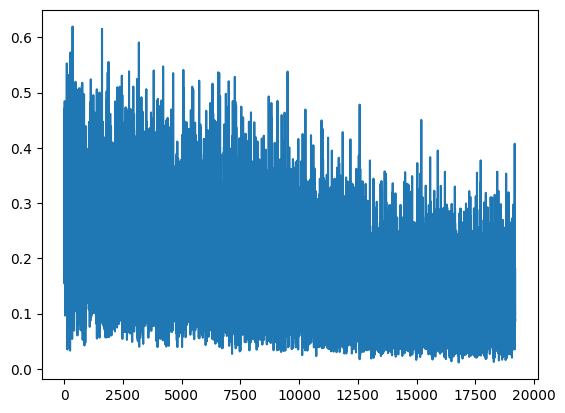

In [39]:
plt.figure()
plt.plot(losses_np)

In [16]:
# q_agent.train(1024)

In [40]:
q_agent.buffer.size

100000

### Using RND

In [61]:
use_target = True
target_update = 20
q_rnd_agent = DQNRNDAgent(o_space, ac_space, discount=0.95, eps=1.0, 
                   use_target_net=use_target, update_target_every= target_update)

In [62]:
ob,_info = env.reset()
obs_agent2 = env.obs_agent_two()
player2 = h_env.BasicOpponent(weak=True)
print(ob)
print(q_rnd_agent.Q.predict(ob))
print(q_rnd_agent.rnd.intrinsic_reward(torch.from_numpy(ob.astype(np.float32))))

[-3.          0.          0.          0.          0.          0.
  3.          0.          0.          0.          0.          0.
 -1.8534143  -0.44299006  0.          0.          0.          0.        ]
[ 0.19105878 -0.13308068  0.13529056 -0.25908923  0.09729928  0.01348766
 -0.29440814  0.0272974 ]
tensor(0.0169, grad_fn=<MseLossBackward0>)


In [63]:
stats = []
stats_intrinsic = []
losses = []
wins = []

In [64]:
# with intrinsic rewards
max_episodes=1200
max_steps=500 
# total_intrinsic_reward = 0
# list_rew_i = []
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    total_intrinsic_reward = 0
    list_rew_i = []
    ob, _info = env.reset()
    obs_agent2 = env.obs_agent_two()
    for t in range(max_steps):
        done = False        
        a1_discrete = q_rnd_agent.act(ob)
        a1 = env.discrete_to_continous_action(a1_discrete)
        a2 = player2.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1,a2]))
        total_reward+= reward
        # get intrinsic rewards
        reward_i = q_rnd_agent.rnd.intrinsic_reward(torch.from_numpy(ob.astype(np.float32))).detach().clamp(-1.0, 1.0).item()
        list_rew_i.append(reward_i)
        
        # find combined reward
        if t==0:
            combined_reward = reward + reward_i
            total_intrinsic_reward+= reward_i
        elif t>0:
            # normalise intrinsic rewards by running std
            # random = np.random.rand() * 10 # for control with random intrinsic reward
            reward_i_norm = reward_i/np.std(list_rew_i) # normalised intrinsic reward
            combined_reward = reward + reward_i
            total_intrinsic_reward+= reward_i
        q_rnd_agent.store_transition((ob, a1_discrete, combined_reward, ob_new, done))            
        ob=ob_new  
        obs_agent2 = env.obs_agent_two()      
        if done or trunc: break   
    wins.append(_info['winner'])
    losses.extend(q_rnd_agent.train(32))
    stats.append([i,total_reward,t+1])
    stats_intrinsic.append([i,total_intrinsic_reward,t+1])
    
    if ((i-1)%20==0):
        sum_wins = np.sum(np.array(wins)==1)
        print("{}: Done after {} steps. Reward: {}. Intrinsic Reward: {} Total wins: {}".format(
            i, t+1, total_reward, total_intrinsic_reward, sum_wins))
        
    if q_rnd_agent._eps > q_rnd_agent._config['eps_min']:
        q_rnd_agent._eps *= q_rnd_agent._config['eps_decay'] 

1: Done after 251 steps. Reward: -36.498437805333594. Intrinsic Reward: 6.353797632735223 Total wins: 0
21: Done after 251 steps. Reward: -34.37998818844054. Intrinsic Reward: 9.875837654806674 Total wins: 1
41: Done after 251 steps. Reward: -54.41361666908499. Intrinsic Reward: 10.567734773270786 Total wins: 1
61: Done after 251 steps. Reward: -30.95348166322144. Intrinsic Reward: 23.165515707805753 Total wins: 1
81: Done after 251 steps. Reward: -33.16735828754334. Intrinsic Reward: 67.81470598652959 Total wins: 1
101: Done after 23 steps. Reward: -11.774185378599627. Intrinsic Reward: 4.975037068128586 Total wins: 3
121: Done after 251 steps. Reward: -30.734341826109. Intrinsic Reward: 53.54167861305177 Total wins: 7
141: Done after 83 steps. Reward: 0.01268865612204273. Intrinsic Reward: 21.40014862269163 Total wins: 9
161: Done after 251 steps. Reward: -25.433169747097732. Intrinsic Reward: 93.22453589551151 Total wins: 11
181: Done after 200 steps. Reward: -30.675468910906513. In

/var/folders/r5/35ml8bds4xgg92vk489jvb0r0007ds/T/ipykernel_41711/1049853573.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  reward_i_norm = reward_i/np.std(list_rew_i) # normalised intrinsic reward


241: Done after 72 steps. Reward: 11.266615782079048. Intrinsic Reward: 63.909018129110336 Total wins: 20
261: Done after 251 steps. Reward: -36.188966569698245. Intrinsic Reward: 181.20677779614925 Total wins: 22
281: Done after 99 steps. Reward: -11.130385418794344. Intrinsic Reward: 80.62548659741879 Total wins: 23
301: Done after 102 steps. Reward: -14.879362167430752. Intrinsic Reward: 53.853367272764444 Total wins: 25
321: Done after 220 steps. Reward: 7.29986337049345. Intrinsic Reward: 104.47989499662071 Total wins: 26
341: Done after 251 steps. Reward: -21.50683747326714. Intrinsic Reward: 175.77562138810754 Total wins: 31
361: Done after 251 steps. Reward: -19.29362953444118. Intrinsic Reward: 164.64053177461028 Total wins: 31
381: Done after 251 steps. Reward: -17.43001465912728. Intrinsic Reward: 139.33370515704155 Total wins: 34
401: Done after 22 steps. Reward: 10.21043353276153. Intrinsic Reward: 7.288047701120377 Total wins: 36
421: Done after 251 steps. Reward: -18.002

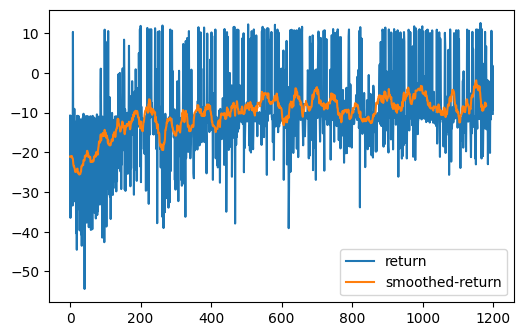

In [66]:
stats_np = np.asarray(stats)
stats_intrinsic_np = np.asarray(stats_intrinsic)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

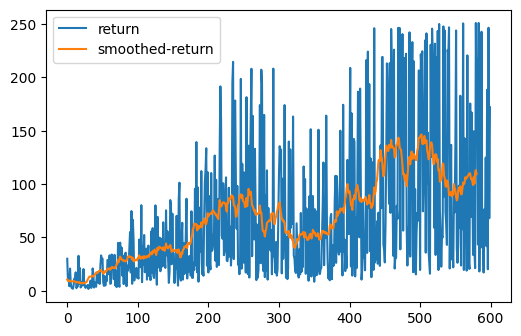

In [65]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_intrinsic_np[:,1], label="return")
plt.plot(running_mean(stats_intrinsic_np[:,1],20), label="smoothed-return")
plt.legend()

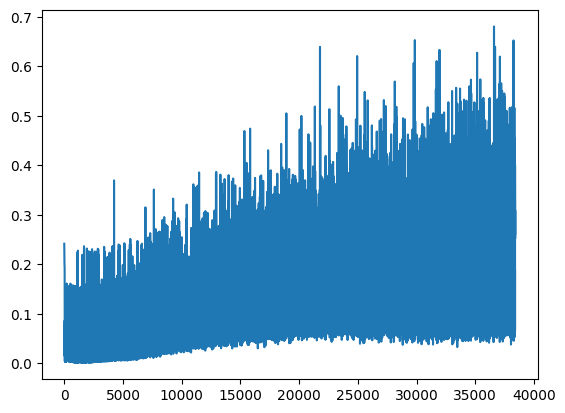

In [67]:
plt.figure()
losses_new = losses_np[np.where(losses_np<10)[0]]
plt.plot(losses_new)

## Evaluate (without exploration)

### Without RND

In [61]:
env = h_env.HockeyEnv()
env.discretize_actions(8)

In [62]:
test_stats = []
wins = []
episodes=10
info = []
for i in range(episodes):
    total_reward = 0
    ob, _info = env.reset()
    obs_agent2 = env.obs_agent_two()
    for t in range(max_steps):
        env.render()
        done = False        
        a1_discrete = q_agent.act(ob, eps=0.0)
        a1 = env.action(a1_discrete)
        a2 = player2.act(obs_agent2) # np.random.uniform(-1,1,4) #
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1,a2]))
        info.append(_info)
        total_reward+= reward
        ob=ob_new
        obs_agent2 = env.obs_agent_two()        
        if done: break    
    test_stats.append([i,total_reward,t+1]) 
    wins.append(_info['winner'])       

In [58]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))
print(np.sum(np.array(wins)==1))
print(np.sum(np.array(wins)==0))

-4.316320891719487 +- 9.705938456456353
25
29


### With RND

In [88]:
env = h_env.HockeyEnv()
env.discretize_actions(8)

In [79]:
test_stats = []
wins = []
episodes=50

for i in range(episodes):
    total_reward = 0
    ob, _info = env.reset()
    obs_agent2 = env.obs_agent_two()
    for t in range(max_steps):
        #env.render()
        done = False        
        a1_discrete = q_rnd_agent.act(ob, eps=0.0)
        a1 = env.discrete_to_continous_action(a1_discrete)
        a2 = player2.act(obs_agent2)
        (ob_new, reward, done, trunc, _info) = env.step(np.hstack([a1,a2]))
        total_reward+= reward
        ob=ob_new
        obs_agent2 = env.obs_agent_two()        
        if done: break    
    test_stats.append([i,total_reward,t+1]) 
    wins.append(_info['winner'])               

In [80]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))
print(np.sum(np.array(wins)==1))
print(np.sum(np.array(wins)==0))

-8.347489916484115 +- 8.589518155464356
7
9
